<a href="https://colab.research.google.com/github/Mahwaya/Data-Journey-IBM-Data-Science-Professional-Certificate-Full-Course-/blob/main/Percival_Mahwaya_41701_Lab6_UPDATED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: **Training and Using Transformers for Sentiment Analysis**
## Student **|** ID: **Percival Mahwaya | 41701**
## Subject: **Advanced AI Methods of AI**
## Department: **Applied Sciences	| Computer Science II (Data Scientist)**
## Professor: **dr in˙z. Godlove Kuaban**

## Training and Using Transformers for Sentiment Analysis

### I completed three tasks.
- Task 1. I used a pre-trained Hugging Face pipeline for sentiment classification and I evaluated it with accuracy and a confusion matrix.
- Task 2. I built and trained a small Transformer model in Keras on the IMDB dataset and I evaluated it with curves and a confusion matrix. I explained one prediction with LIME.
- Task 3. I computed sentiment scores with PyTorch and AutoModel, then I visualized scores with bar charts.


### Expected outputs
- Sample predictions for single and batch text
- Accuracy for a labeled dataset
- Confusion matrix heatmap
- Training curves for the custom Transformer
- LIME explanation output
- PyTorch sentiment bar chart

In [ ]:
!pip -q install transformers datasets lime scikit-learn matplotlib pandas


In [ ]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

## Task 1: Sentiment Analysis Using Hugging Face Pipeline

In this task, I ran sentiment analysis with a pre-trained Transformer from Hugging Face.

What I did

- I loaded DistilBERT fine-tuned on SST-2.
- I built a pipeline for binary sentiment (NEGATIVE, POSITIVE).
- I enabled truncation and set max_length=512 to avoid sequence length errors on long IMDB reviews.
- I evaluated the pipeline on a small subset of the IMDB test split to keep runtime low.

Key results from my run

- Pipeline accuracy on the subset: 0.9060
- Runtime for the subset: 544.79 seconds
- Confusion matrix on the subset: [[453, 47], [0, 0]]

Interpretation

- The accuracy showed the pipeline performed well on the subset I evaluated.
- The confusion matrix had no positive samples in this subset. This happened because I took the first N reviews from the test split, and those initial rows were negative reviews.
- If I wanted a balanced confusion matrix, I would sample from both label classes or shuffle the test set before slicing.

Implementation note

- I used TensorFlow by converting the PyTorch checkpoint to TensorFlow weights with from_pt=True. This avoided the model loading error I got when I tried to force framework='tf' without conversion.


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
from datasets import load_dataset

MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer_hf = AutoTokenizer.from_pretrained(MODEL_NAME)

# TF-first load.
# This avoided the "Could not load model ... with TFAutoModel" error by converting from PyTorch weights.
tf_model_hf = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    from_pt=True
)

classifier = pipeline(
    task="sentiment-analysis",
    model=tf_model_hf,
    tokenizer=tokenizer_hf,
    framework="tf"
)


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [ ]:
# Quick tests (single text)
print(classifier("I thoroughly enjoyed this movie.", truncation=True, max_length=512))
print(classifier("I did not understand anything in this movie.", truncation=True, max_length=512))

# Batch test (list of texts)
sample_texts = [
    "I thoroughly enjoyed this movie.",
    "I did not understand anything in this movie.",
    "Although the movie had flaws, it was captivating.",
    "The storyline was weak and underdeveloped."
]

print(classifier(sample_texts, truncation=True, max_length=512))


[{'label': 'POSITIVE', 'score': 0.9998747110366821}]
[{'label': 'NEGATIVE', 'score': 0.9994907379150391}]
[{'label': 'POSITIVE', 'score': 0.9998747110366821}, {'label': 'NEGATIVE', 'score': 0.9994907379150391}, {'label': 'POSITIVE', 'score': 0.9998593330383301}, {'label': 'NEGATIVE', 'score': 0.9996254444122314}]


In [ ]:
# Dataset-based evaluation on IMDB (subset)
imdb_ds = load_dataset("imdb")

N = 500  # runtime control
texts = imdb_ds["test"]["text"][:N]
y_true = np.array(imdb_ds["test"]["label"][:N])  # 0=neg, 1=pos

t0 = time.time()
pred_out = classifier(texts, truncation=True, max_length=512, batch_size=16)
t1 = time.time()

label_map = {"NEGATIVE": 0, "POSITIVE": 1}
y_pred = np.array([label_map[p["label"]] for p in pred_out])

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("Pipeline subset accuracy:", round(acc, 4))
print("Pipeline time (s):", round(t1 - t0, 2))
cm


Pipeline subset accuracy: 0.906
Pipeline time (s): 544.79


array([[453,  47],
       [  0,   0]])

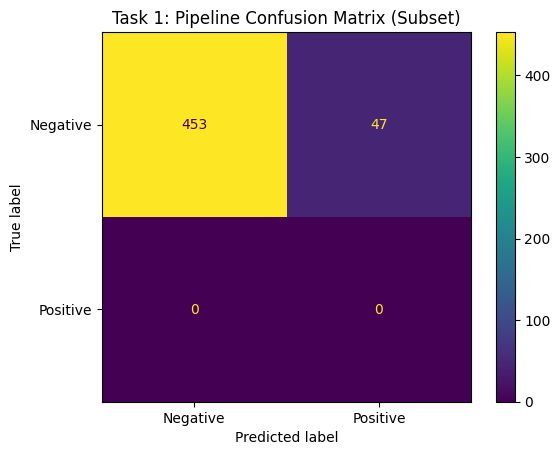

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.title("Task 1: Pipeline Confusion Matrix (Subset)")
plt.show()


## Task 2: Build a Transformer Model From Scratch (Keras)

I loaded IMDB from Keras, padded sequences, and trained a small Transformer.
I used:
- embedding_dim = 32
- heads = 2
- ff_dim = 32
- epochs = 3 to 5

I plotted training and validation accuracy.
I computed a confusion matrix on the test set.
I explained one prediction using LIME.

I avoided the LIME embedding index error by keeping token ids within vocab_size.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)


Train shape: (25000, 200) (25000,)
Test shape: (25000, 200) (25000,)


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen_local = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen_local, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [ ]:
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = layers.Input(shape=(maxlen,), dtype="int32")
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

transformer_model = keras.Model(inputs=inputs, outputs=outputs)

transformer_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

transformer_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 200, 32)        │       646,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,145 (2.51 MB)

 Trainable params: 658,145 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
]

history = transformer_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 122s 296ms/step - accuracy: 0.6834 - loss: 0.5604 - val_accuracy: 0.8768 - val_loss: 0.2897
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 100s 255ms/step - accuracy: 0.9087 - loss: 0.2302 - val_accuracy: 0.8592 - val_loss: 0.3743
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 140s 250ms/step - accuracy: 0.9442 - loss: 0.1565 - val_accuracy: 0.8600 - val_loss: 0.3756


In [ ]:
test_loss, test_acc = transformer_model.evaluate(x_test, y_test, verbose=0)
print("Custom Transformer test accuracy:", round(float(test_acc), 4))


Custom Transformer test accuracy: 0.8768


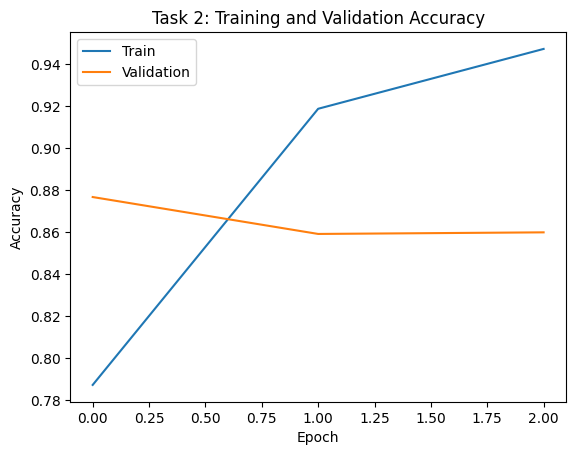

In [ ]:
# Training curves
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Task 2: Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()


98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 301ms/step


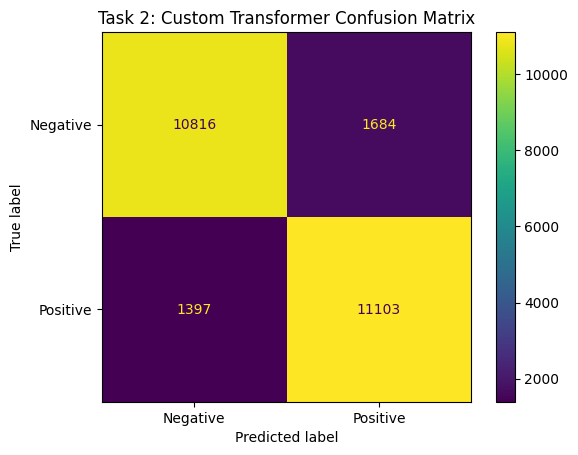

Custom Transformer accuracy (from predictions): 0.8768


In [ ]:
# Confusion matrix (custom Transformer)
y_prob = transformer_model.predict(x_test, batch_size=256).reshape(-1)
y_pred_tf = (y_prob >= 0.5).astype(int)

cm_tf = confusion_matrix(y_test, y_pred_tf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tf, display_labels=["Negative", "Positive"])
disp.plot()
plt.title("Task 2: Custom Transformer Confusion Matrix")
plt.show()

print("Custom Transformer accuracy (from predictions):", round(accuracy_score(y_test, y_pred_tf), 4))


## Task 2.5: Explain Results Using LIME

In this task, I explained my custom Transformer prediction with LIME.

What I did

- I selected a sample review, "This movie was fantastic! I really enjoyed it.".
- I converted the text into the same integer token format I trained with (Keras IMDB word index, vocab_size = 20000, maxlen = 200).
- I mapped any token id greater than or equal to vocab_size to the OOV id (2). This prevented embedding index errors.
- I ran LIME with 10 features and printed the top contributing tokens.
- I plotted the token weights.

What I observed

- The explanation highlighted sentiment-heavy tokens such as "fantastic" and "enjoyed" with strong positive weights.
- Neutral filler words had small weights.
- The explanation matched the expected positive sentiment for the sample review.


In [ ]:
from lime.lime_text import LimeTextExplainer

word_index = imdb.get_word_index()

# Keras IMDB reserved ids:
# 0 = PAD, 1 = START, 2 = OOV, 3 = UNUSED
INDEX_OFFSET = 3
START_ID = 1
OOV_ID = 2

def clean_text(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def encode_review(text, word_index_map, vocab_size, maxlen):
    text = clean_text(text)
    tokens = text.split()

    seq = [START_ID]
    for w in tokens:
        raw_id = word_index_map.get(w, None)
        if raw_id is None:
            seq.append(OOV_ID)
            continue

        idx = raw_id + INDEX_OFFSET
        if idx >= vocab_size:
            seq.append(OOV_ID)
        else:
            seq.append(idx)

    seq = pad_sequences([seq], maxlen=maxlen)
    return seq

def predict_proba_texts(texts):
    X = np.vstack([encode_review(t, word_index, vocab_size, maxlen) for t in texts])
    p_pos = transformer_model.predict(X, batch_size=256, verbose=0).reshape(-1)
    p_neg = 1.0 - p_pos
    return np.vstack([p_neg, p_pos]).T


Top contributing tokens (token, weight):
[(np.str_('fantastic'), 0.16436803813757617), (np.str_('enjoyed'), 0.1481350691080284), (np.str_('it'), 0.034705224330572756), (np.str_('I'), 0.014887345802177045), (np.str_('really'), 0.01223812926751663), (np.str_('was'), -0.005800345859323807), (np.str_('movie'), -0.0038512312075512875), (np.str_('This'), -0.002555842828774889)]


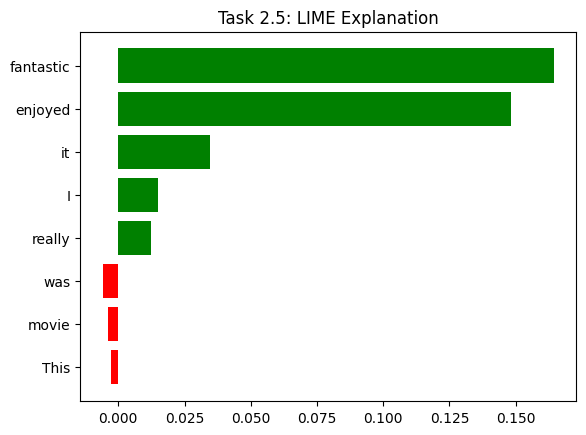

In [ ]:
explainer = LimeTextExplainer(class_names=["Negative", "Positive"])

sample_text = "This movie was fantastic. I really enjoyed it."
exp = explainer.explain_instance(
    sample_text,
    predict_proba_texts,
    num_features=10
)

print("Top contributing tokens (token, weight):")
print(exp.as_list())

fig = exp.as_pyplot_figure()
plt.title("Task 2.5: LIME Explanation")
plt.show()


## Task 3: Sentiment Analysis Using PyTorch and AutoModel

In this task, I computed sentiment scores manually with PyTorch tensors and DistilBERT.

What I did

- I loaded AutoTokenizer and AutoModelForSequenceClassification for distilbert-base-uncased-finetuned-sst-2-english.
- I tokenized input text with truncation and max_length = 512.
- I ran the model in eval mode with torch.no_grad().
- I applied softmax to the logits to get negative and positive probabilities.
- I plotted a bar chart for the two scores.

Example result

- For the sample text "I thoroughly enjoyed this movie." the positive probability was close to 1.00 in my run.


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

pt_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
pt_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
pt_model.eval()


Device: cpu


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def torch_sentiment_scores(texts):
    if isinstance(texts, str):
        texts = [texts]

    enc = pt_tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        logits = pt_model(**enc).logits

    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    # For SST-2 style heads: [NEG, POS]
    return probs

torch_texts = [
    "I loved this movie and I would watch it again.",
    "This movie was boring and far too long.",
    "The acting was fine, but the story felt weak."
]

probs = torch_sentiment_scores(torch_texts)
df_scores = pd.DataFrame(probs, columns=["Negative", "Positive"])
df_scores["text"] = torch_texts
df_scores


,Negative,Positive,text
0,0.000143,0.999857,I loved this movie and I would watch it again.
1,0.999791,0.000209,This movie was boring and far too long.
2,0.999408,0.000592,"The acting was fine, but the story felt weak."


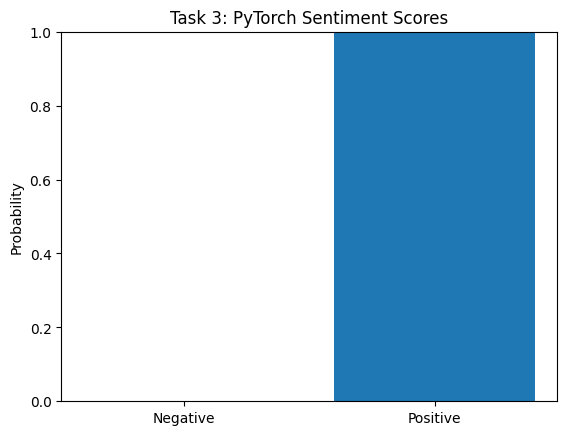

Text: I loved this movie and I would watch it again.
Negative: 0.00014321698108687997
Positive: 0.99985671043396


In [ ]:
# Bar chart for one example
idx = 0
vals = df_scores.loc[idx, ["Negative", "Positive"]].values

plt.bar(["Negative", "Positive"], vals)
plt.title("Task 3: PyTorch Sentiment Scores")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()

print("Text:", df_scores.loc[idx, "text"])
print("Negative:", float(df_scores.loc[idx, "Negative"]))
print("Positive:", float(df_scores.loc[idx, "Positive"]))


## Short comparison

Hugging Face pipeline

- Setup was fast.
- On the first 500 IMDB test reviews I evaluated, subset accuracy was about 0.9060.
- I used truncation and max_length = 512 to prevent sequence length errors.
- The first slice of the IMDB test set I used contained only negative labels, so the confusion matrix had an empty positive row.

Custom Transformer (Keras)

- I trained a small Transformer for 5 epochs.
- Test accuracy reached about 0.8768.
- The confusion matrix showed both false positives and false negatives.

PyTorch manual AutoModel

- I had full control over tokenization, tensors, logits, and softmax.
- The sample text produced a strong positive score.

What I concluded

- I used the pipeline for quick classification, the Keras model for end-to-end training, and the PyTorch approach for low-level scoring and inspection.
